In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from IPython.display import display, HTML, clear_output
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import BayesianRidge
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, Flatten, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

In [2]:
dhh_max = r'C:\Users\ing_l\Tesis grado\Data\Predictors data\Dataset2019_half_hour_max.csv'
dhour_max = r'C:\Users\ing_l\Tesis grado\Data\Predictors data\Dataset2019_hour_max.csv'
dhh_mean = r'C:\Users\ing_l\Tesis grado\Data\Predictors data\Dataset2019_half_hour_mean.csv'
dhour_mean = r'C:\Users\ing_l\Tesis grado\Data\Predictors data\Dataset2019_hour_mean.csv'

In [3]:
data = pd.read_csv(dhh_max)
tiempo = 'media hora'

data.drop('Unnamed: 0', axis=1, inplace=True)
data['fecha'] = data['fecha'].apply(lambda x: pd.to_datetime(x).date())
d = data.copy()
data

,dia de la semana,fecha,id_cuadra,media hora,mes,ocupacion,ocupacion anterior,targets
0,2,2019-01-02,0,36000,1,2,3,1
1,2,2019-01-02,0,37800,1,1,2,5
2,2,2019-01-02,0,39600,1,5,1,4
3,2,2019-01-02,0,41400,1,4,5,2
4,2,2019-01-02,0,43200,1,2,4,3
...,...,...,...,...,...,...,...,...
476452,1,2019-09-17,190,39600,9,1,1,1
476453,1,2019-09-17,190,41400,9,1,1,1
476454,1,2019-11-12,190,36000,11,0,0,1
476455,1,2019-11-19,190,34200,11,1,1,1


### Se eliminan los fines de semana (para tener los datos lo mas parejo posible)

In [4]:
# Eliminamos los fines de semana
data = data.loc[data['dia de la semana'] < 5]

###  Se eliminan los outliers

Street: 190


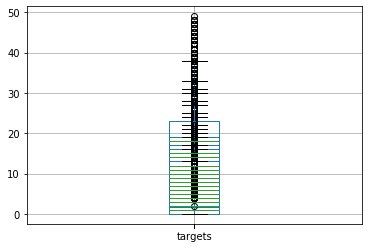

In [5]:
data_no_outliers = pd.DataFrame(columns=data.columns)
for s in data['id_cuadra'].drop_duplicates().sort_values():
    clear_output()
    print('Street:', s)
    
    data_street = data.loc[data['id_cuadra'] == s]
    outlier = data_street.boxplot(column='targets', return_type='dict')['whiskers'][1].get_ydata()[1]
    
    data_no_outliers = data_no_outliers.append(data_street.loc[data_street['targets'] <= outlier])

### Normalizamos la feature "media hora" que posee valores demasiado altos

#### Para esto se hace x / (valor de un hora en segundos) = hora

In [6]:
if 'media hora' in tiempo:
    data_no_outliers[tiempo] = data_no_outliers[tiempo] / (1800 * 2)

In [7]:
data_no_outliers = data_no_outliers.loc[(data_no_outliers['media hora'] > 8) &  (data_no_outliers['media hora'] < 20)]

In [8]:
data_no_outliers

,dia de la semana,fecha,id_cuadra,media hora,mes,ocupacion,ocupacion anterior,targets
0,2,2019-01-02,0,10,1,2,3,1
1,2,2019-01-02,0,10.5,1,1,2,5
2,2,2019-01-02,0,11,1,5,1,4
3,2,2019-01-02,0,11.5,1,4,5,2
4,2,2019-01-02,0,12,1,2,4,3
...,...,...,...,...,...,...,...,...
476452,1,2019-09-17,190,11,9,1,1,1
476453,1,2019-09-17,190,11.5,9,1,1,1
476454,1,2019-11-12,190,10,11,0,0,1
476455,1,2019-11-19,190,9.5,11,1,1,1


### Se eligen los features de input

In [9]:
input_features_cat = ['id_cuadra', 'mes', 'dia de la semana', tiempo, 'ocupacion', 'ocupacion anterior']
input_features_no_cat = ['id_cuadra', tiempo, 'ocupacion', 'ocupacion anterior']
input_features_no_cat_no_street = [tiempo, 'ocupacion', 'ocupacion anterior']

### Se eligen los datos de validacion

In [10]:
cuadra1 = 12
fecha1 = 1

fecha1 = data_no_outliers['fecha'].drop_duplicates().iloc[fecha1]

filt = (data_no_outliers['id_cuadra'] == cuadra1) & (data_no_outliers['fecha'] == fecha1) 
x_val1 = data_no_outliers.loc[filt, input_features_cat]
y_val1 = data_no_outliers.loc[filt, 'targets']

data_no_outliers = data_no_outliers.loc[~filt]

In [11]:
x_val1

,id_cuadra,mes,dia de la semana,media hora,ocupacion,ocupacion anterior
69693,12,1,3,10,7,3
69694,12,1,3,10.5,11,7
69695,12,1,3,11,14,11
69696,12,1,3,11.5,16,14
69697,12,1,3,12,17,16
69698,12,1,3,12.5,10,17
69699,12,1,3,13,8,10
69700,12,1,3,13.5,9,8
69701,12,1,3,14.5,9,9
69702,12,1,3,15,7,9


In [12]:
cuadra2 = 32
fecha2 = 16

fecha2 = data_no_outliers['fecha'].drop_duplicates().iloc[fecha2]

filt = (data_no_outliers['id_cuadra'] == cuadra2) & (data_no_outliers['fecha'] == fecha2) 
x_val2 = data_no_outliers.loc[filt, input_features_cat]
y_val2 = data_no_outliers.loc[filt, 'targets']

data_no_outliers = data_no_outliers.loc[~filt]

In [13]:
x_val2

,id_cuadra,mes,dia de la semana,media hora,ocupacion,ocupacion anterior
181813,32,1,4,9.5,4,3
181814,32,1,4,10,7,4
181815,32,1,4,10.5,10,7
181816,32,1,4,11,10,10
181817,32,1,4,11.5,8,10
181818,32,1,4,12,9,8
181819,32,1,4,12.5,8,9
181820,32,1,4,13,5,8
181821,32,1,4,13.5,6,5
181822,32,1,4,14,9,6


### Se divide en test y train y se eligen los parametros con mayor correlacion

In [14]:
#Con outliers
#data_to_split = data
#Sin outliers

data_to_split = data_no_outliers

#x_train, x_test, y_train, y_test = train_test_split(data_to_split[input_features], data_to_split['targets'], test_size=0.2, shuffle=True, stratify=data_to_split['targets'])

#Sin outliers
x_train, x_test, y_train, y_test = train_test_split(data_to_split[input_features_cat], data_to_split['targets'], test_size=0.1, shuffle=True)   

### Funcion para plotear los datos predichos

In [ ]:
def plot_predicted_data(predictions, x_val=None, y_val=None):
    try:
        try:
            predictions = [round(x[0]) for x in predictions]
        except:
            predictions = [round(x) for x in predictions]
    except:
        predictions = predictions
    targets_time = x_val[tiempo] + 1 # 1 = normalized half hour

    plt.rcParams['figure.figsize'] = (15,8)

    plt.plot(targets_time, y_val, color='blue')
    plt.scatter(targets_time, y_val, color='blue')
    
    plt.scatter(targets_time, predictions, color='orange')
    plt.plot(targets_time, predictions, color='orange')
    plt.legend(['Y','Yhat'])  
    
    plt.grid()
    plt.xlabel('Tiempo (h)')
    plt.ylabel('Ocupacion')

    clear_output()
    plt.show()
    #out = x_val.copy()
    #out['targets'] = y_val
    #out['predicted targets'] = predictions
    #display(out)

# Baseline ocupacion input == output

In [16]:
r2_misma_pred = r2_score(y_test, x_test['ocupacion'])
print("Score (R2):", r2_misma_pred)

Score (R2): 0.8033200747350281


In [17]:
mse_misma_pred = mean_squared_error(y_test, x_test['ocupacion'])
print("Score (RMSE):", sqrt(mse_misma_pred))

Score (RMSE): 2.2417357674009613


.

.

.

.

# Predictores!

# Bayesian Ridge

### full dataset

In [18]:
model = BayesianRidge()
model.fit(x_train[input_features_no_cat_no_street], y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [19]:
print('Score total (R^2):                    ', model.score(x_test[input_features_no_cat_no_street], y_test))
print('Score total (RMSE):                   ', sqrt(mean_squared_error(y_test, model.predict(x_test[input_features_no_cat_no_street]))))

Score total (R^2):                     0.8235769342263719
Score total (RMSE):                    2.1313867256206183


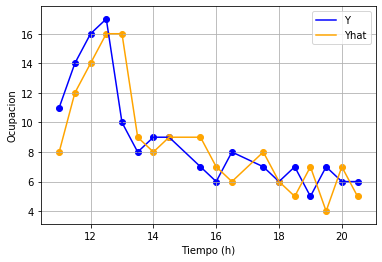

In [20]:
plot_predicted_data(model.predict(x_val1[input_features_no_cat_no_street]), x_val1[input_features_no_cat_no_street], y_val1)#, to_left=True)

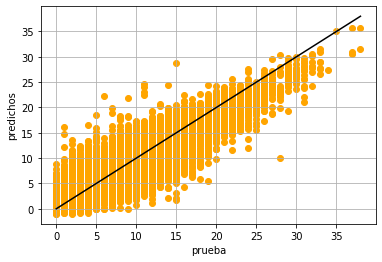

In [21]:
plt.scatter(y_test, model.predict(x_test[input_features_no_cat_no_street]), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

### Por cuadra

In [22]:
scores = []
models = []
for s in data['id_cuadra'].drop_duplicates().sort_values():
    clear_output()
    print('Street:', s)

    model = BayesianRidge()
    
    x = x_train[input_features_no_cat].loc[x_train['id_cuadra'] == s]
    train_indexes = x.index
    model.fit(x, y_train.loc[train_indexes])
    
    models.append(model)
    
    x_t = x_test[input_features_no_cat].loc[x_test['id_cuadra'] == s]
    if len(x_t) > 0:
        scores.append(model.score(x_t, y_test.loc[x_t.index]))

Street: 190


C:\Users\ing_l\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


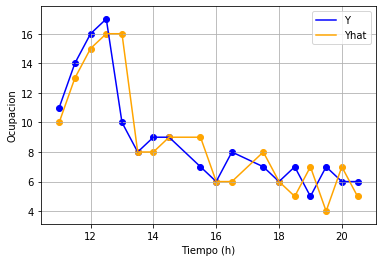

In [23]:
model_ix = data['id_cuadra'].drop_duplicates().sort_values().reset_index(drop=True)
model_ix = model_ix.loc[model_ix == cuadra1].index.astype(int)
model_ix = model_ix[0]

plot_predicted_data(models[model_ix].predict(x_val1[input_features_no_cat]), x_val1, y_val1)

In [24]:
#Para obtener el RMSE
RMSE = 0
for s in data['id_cuadra'].drop_duplicates().sort_values():
    
    x = x_test[input_features_no_cat].loc[x_test['id_cuadra'] == s]
    if len(x) > 0:
        RMSE += sqrt(mean_squared_error(y_test.loc[x.index], model.predict(x)))
RMSE = RMSE / len(data['id_cuadra'].drop_duplicates())

Score total (R^2):   nan
Score total (RMSE):  5.978556528841996


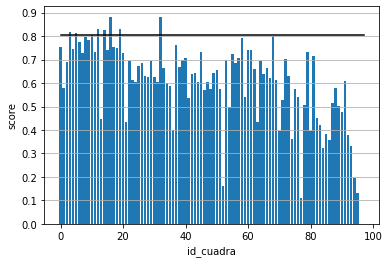

In [25]:
total_score = sum(scores) / len(scores)
print('Score total (R^2):  ', total_score)
print('Score total (RMSE): ', RMSE)

height = [x for x in range(len(scores))]
plt.bar(height, scores)
plt.rcParams['figure.figsize'] = (15,8)

plt.plot([0,len(scores)], [r2_misma_pred,r2_misma_pred], color='black')
plt.yticks([x for x in np.arange(0, 1, 0.1)])
plt.xlabel('id_cuadra')
plt.ylabel('score')
plt.grid(axis='y')

plt.show()

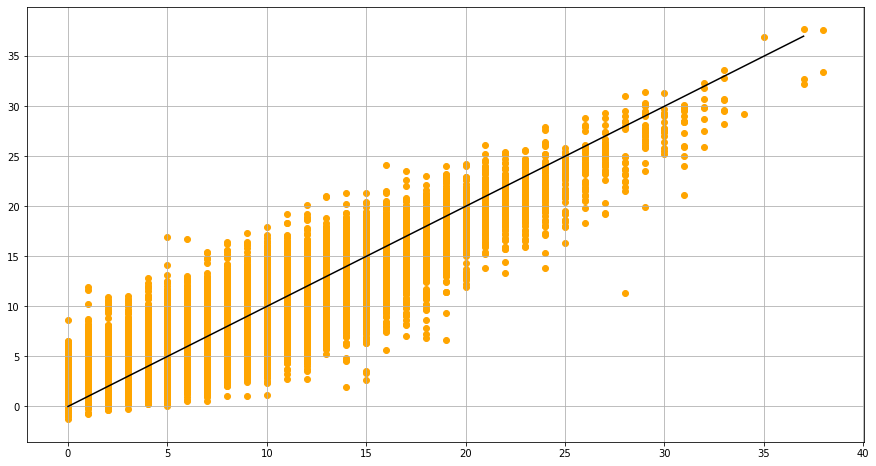

In [26]:
#Podemos mostrar el grafico para las cuadras...
id_cuadra = 0
max_y = 0
for s in range(len(x_test['id_cuadra'].drop_duplicates())):
    clear_output()
    print('Street:', s)
    x = x_test[input_features_no_cat].loc[x_test['id_cuadra'] == s]
    
    if len(x) > 5:
        indexes = x.index
        plt.scatter(y_test.loc[indexes], models[s].predict(x), color='orange')
        if y_test.loc[indexes].max() > max_y:
            max_y = y_test.loc[indexes].max()

clear_output()
plt.plot(range(0, int(max_y)), range(0, int(max_y)), color='black')
plt.grid()
plt.show()

In [27]:
gc.collect()

17735

# Arboles de regresion

### Full dataset

In [28]:
max_depth = 20

best_model = None
best_score = 0

for i in range(1, max_depth+1):
    clear_output()
    print('Profundidad:', i)
    model = tree.DecisionTreeRegressor(max_depth=i)
    model.fit(x_train[input_features_no_cat_no_street], y_train)
    score = model.score(x_test[input_features_no_cat_no_street], y_test)
    
    if score > best_score:
        best_score = score
        best_model = model
        
clear_output()
print('Profundidad del mejor score:', best_model.get_depth())
print('Cantidad de hojas del mejor score:', best_model.get_n_leaves())
print('')
print('Mejor score:', best_score)
print('RMSE:', sqrt(mean_squared_error(y_test, model.predict(x_test[input_features_no_cat_no_street]))))

Profundidad del mejor score: 12
Cantidad de hojas del mejor score: 1775

Mejor score: 0.8562368690499393
RMSE: 1.9489937005883777


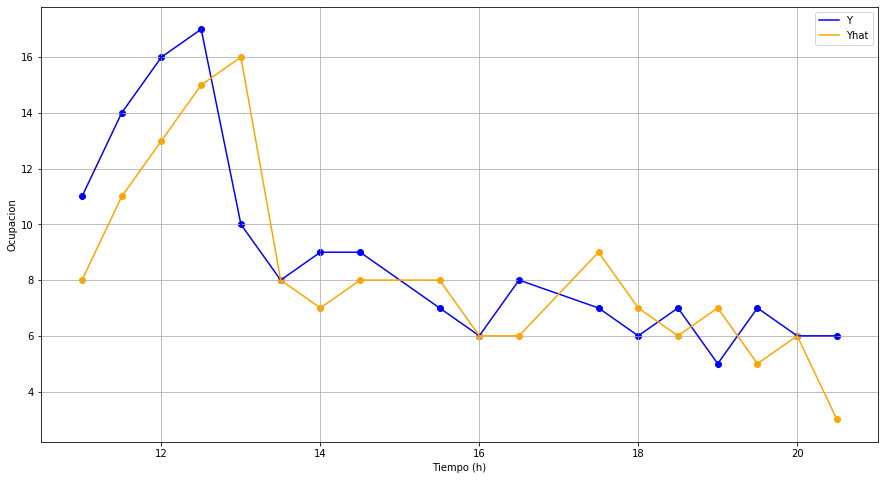

In [29]:
plot_predicted_data(best_model.predict(x_val1[input_features_no_cat_no_street]), x_val1, y_val1)

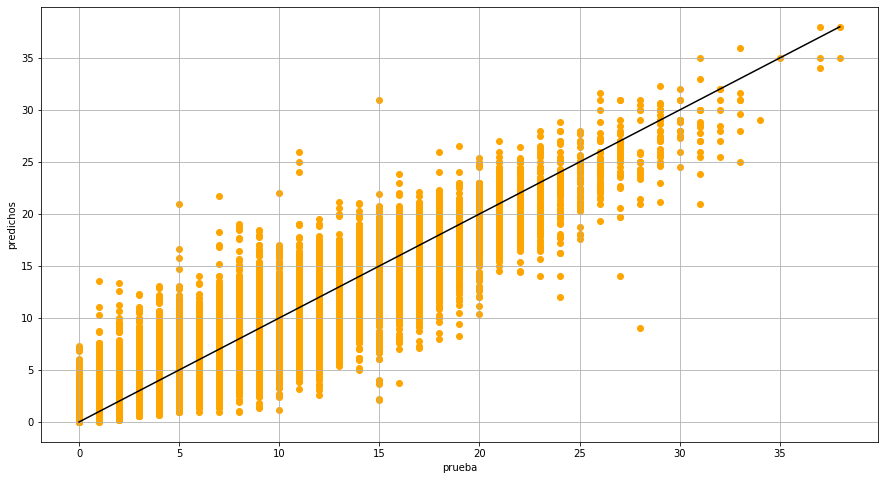

In [30]:
plt.scatter(y_test, model.predict(x_test[input_features_no_cat_no_street]), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

### Por cuadra

In [31]:
max_depth = 20

scores = []
models = []

for s in data['id_cuadra'].drop_duplicates().sort_values():
    clear_output()
    print('Street:', s)

    best_model = None
    best_score = 0
    
    for i in range(1, max_depth+1):
        print('Profundidad:', i)
        
        model = tree.DecisionTreeRegressor(max_depth=i)

        x = x_train[input_features_no_cat].loc[x_train['id_cuadra'] == s]
        train_indexes = x.index
        model.fit(x, y_train.loc[train_indexes])
        
        xt = x_test[input_features_no_cat].loc[x_test['id_cuadra'] == s]
        test_indexes = xt.index
        if len(xt) > 0:
            score = model.score(xt, y_test.loc[test_indexes])
        else:
            score = 0
        if score > best_score:
            best_score = score
            best_model = model
        
    models.append(best_model)

    scores.append(best_score)
    
clear_output()

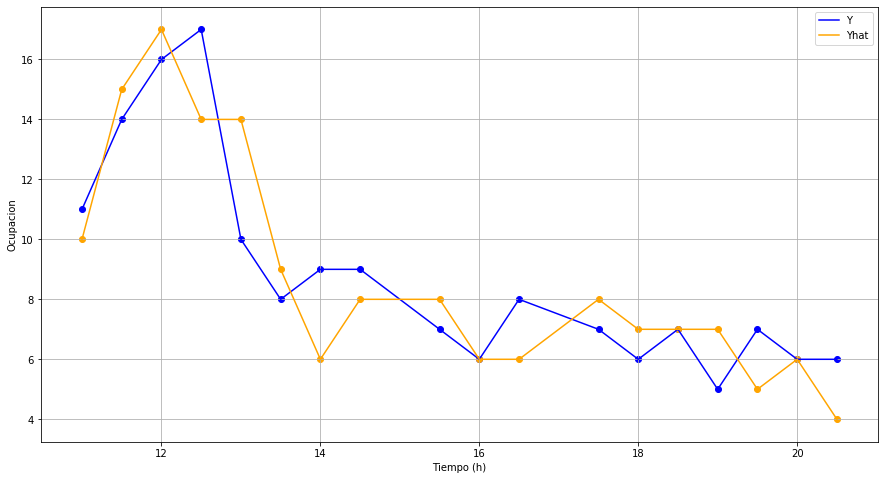

In [32]:
model_ix = data['id_cuadra'].drop_duplicates().sort_values().reset_index(drop=True)
model_ix = model_ix.loc[model_ix == cuadra1].index.astype(int)
model_ix = model_ix[0]

plot_predicted_data(models[model_ix].predict(x_val1[input_features_no_cat]), x_val1, y_val1)

In [33]:
#Para obtener el RMSE
RMSE = 0
index = 0
for s in data['id_cuadra'].drop_duplicates():
    
    x = x_test[input_features_no_cat].loc[x_test['id_cuadra'] == s]
    if len(x) > 0:
        RMSE += sqrt(mean_squared_error(y_test.loc[x.index], model.predict(x)))
    
    index+=1
RMSE = RMSE / len(data['id_cuadra'].drop_duplicates())

Score total (R^2):   0.6485612946604601
Score total (RMSE):  5.978556528841996


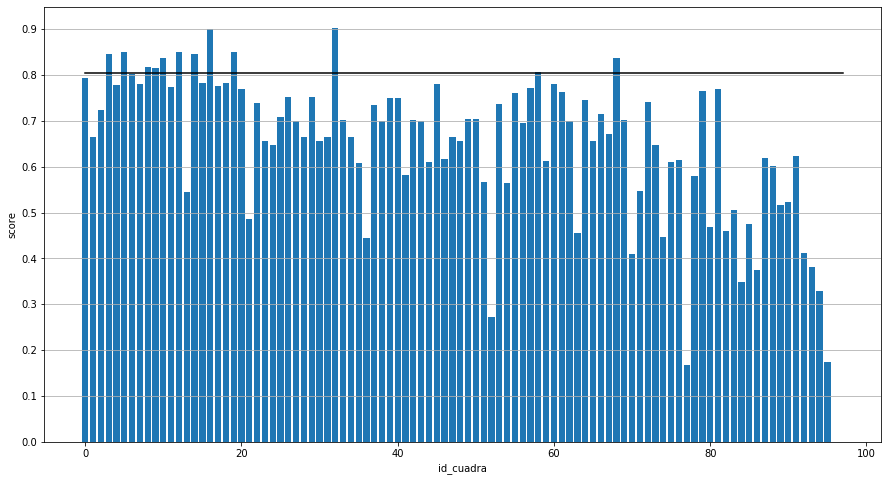

In [34]:
total_score = sum(scores) / len(scores)
print('Score total (R^2):  ', total_score)
print('Score total (RMSE): ', RMSE)

height = [x for x in range(len(scores))]
plt.bar(height, scores)
plt.rcParams['figure.figsize'] = (15,8)

plt.plot([0,len(scores)], [r2_misma_pred,r2_misma_pred], color='black')
plt.yticks([x for x in np.arange(0, 1, 0.1)])
plt.xlabel('id_cuadra')
plt.ylabel('score')
plt.grid(axis='y')

plt.show()

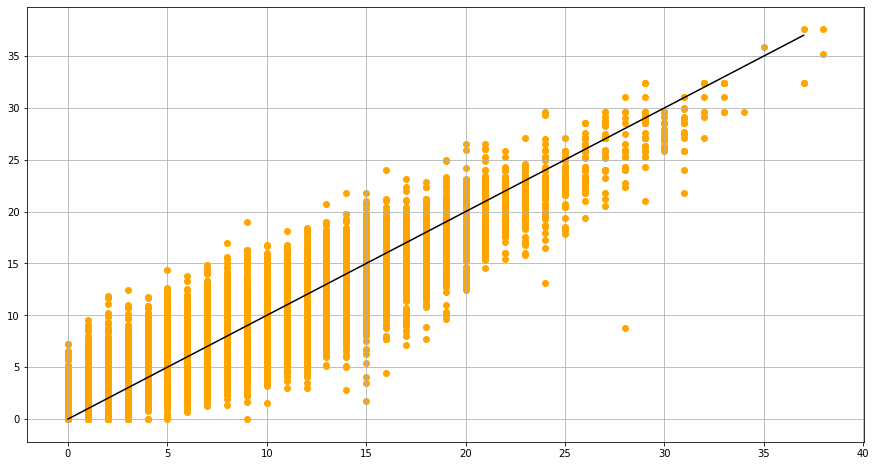

In [35]:
#Podemos mostrar el grafico para las cuadras...
id_cuadra = 0
max_y = 0
for s in range(len(x_test['id_cuadra'].drop_duplicates())):
    clear_output()
    print('Street:', s)
    x = x_test[input_features_no_cat].loc[x_test['id_cuadra'] == s]
    
    if len(x) > 5:
        indexes = x.index
        if models[s] is not None:
            plt.scatter(y_test.loc[indexes], models[s].predict(x), color='orange')
            if y_test.loc[indexes].max() > max_y:
                max_y = y_test.loc[indexes].max()

clear_output()
plt.plot(range(0, int(max_y)), range(0, int(max_y)), color='black')
plt.grid()
plt.show()

# Random forest

In [36]:
max_depth = 20

best_model = None
best_score = 0
best_depth = 0
for i in range(1, max_depth+1):
    clear_output()
    print('Profundidad:', i)
    model = RandomForestRegressor(n_estimators=100, max_depth=i)
    model.fit(x_train[input_features_no_cat_no_street], y_train)
    score = model.score(x_test[input_features_no_cat_no_street], y_test)
    
    if score > best_score:
        best_depth = i
        best_score = score
        best_model = model
        
clear_output()
#print('Profundidad del mejor score:', best_model.get_depth())
#print('Cantidad de hojas del mejor score:', best_model.get_n_leaves())
#print('')
print('Mejor profundidad:', best_depth)
print('Mejor score:', best_score)
print('RMSE:', sqrt(mean_squared_error(y_test, model.predict(x_test[input_features_no_cat_no_street]))))

Mejor profundidad: 11
Mejor score: 0.8570393232734228
RMSE: 1.9381432390870106


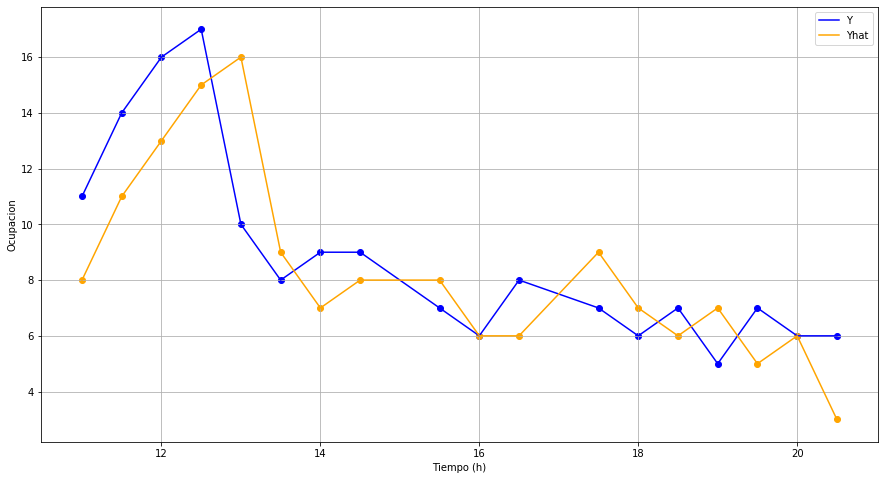

In [37]:
s = 22
plot_predicted_data(best_model.predict(x_val1[input_features_no_cat_no_street]), x_val1, y_val1)

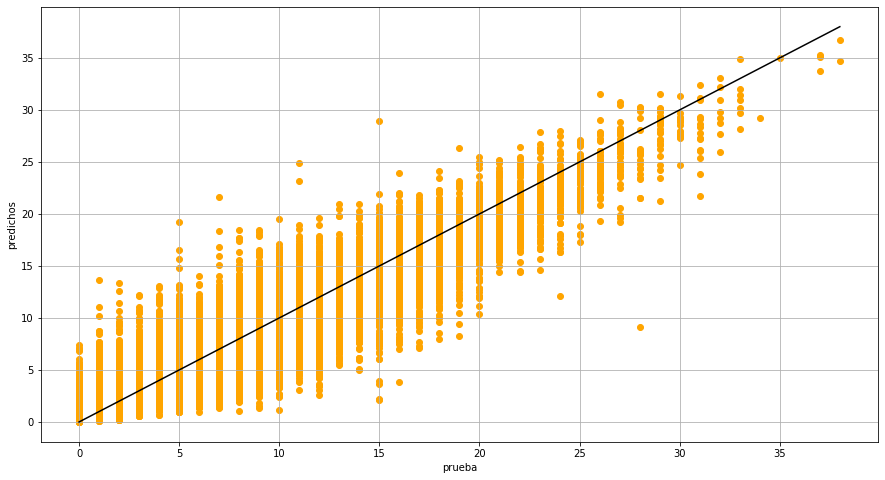

In [38]:
plt.scatter(y_test, model.predict(x_test[input_features_no_cat_no_street]), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

# Redes neuronales

### Regresion lineal

In [39]:
i = Input(shape=(len(input_features_no_cat_no_street)), name='input')
o = Dense(1, activation='linear')(i)

model = Model(inputs=i, outputs=o)
model.summary()
model.compile(loss='MAE', optimizer='adam', metrics=['MSE'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [40]:
h = model.fit(x_train[input_features_no_cat_no_street], y_train, epochs=20, batch_size=64, validation_data=[x_test[input_features_no_cat_no_street],y_test])

Train on 375534 samples, validate on 41727 samples
Epoch 1/20
375534/375534 [==============================] - 5s 14us/sample - loss: 2.1180 - MSE: 10.2119 - val_loss: 1.6215 - val_MSE: 4.6305
Epoch 2/20
375534/375534 [==============================] - 5s 14us/sample - loss: 1.6143 - MSE: 4.5620 - val_loss: 1.6108 - val_MSE: 4.5672
Epoch 3/20
375534/375534 [==============================] - 5s 14us/sample - loss: 1.6085 - MSE: 4.5300 - val_loss: 1.6103 - val_MSE: 4.5483
Epoch 4/20
375534/375534 [==============================] - 5s 14us/sample - loss: 1.6073 - MSE: 4.5249 - val_loss: 1.6094 - val_MSE: 4.5643
Epoch 5/20
375534/375534 [==============================] - 5s 13us/sample - loss: 1.6072 - MSE: 4.5234 - val_loss: 1.6086 - val_MSE: 4.5452
Epoch 6/20
375534/375534 [==============================] - 5s 14us/sample - loss: 1.6072 - MSE: 4.5229 - val_loss: 1.6080 - val_MSE: 4.5544
Epoch 7/20
375534/375534 [==============================] - 5s 13us/sample - loss: 1.6073 - MSE: 4.524

In [41]:
RMSE = sqrt(h.history['val_MSE'][len(h.history['val_MSE'])-1])
print("Score (R2):", r2_score(y_test, model.predict(x_test[input_features_no_cat_no_street])))
print('RMSE:', RMSE)

Score (R2): 0.8233708980480184
RMSE: 2.13263084001291


In [42]:
print('Input features:', input_features_no_cat_no_street)
print('Model weights:', model.layers[1].get_weights()[0])

Input features: ['media hora', 'ocupacion', 'ocupacion anterior']
Model weights: [[-0.11372897]
 [ 1.0377544 ]
 [-0.12798457]]


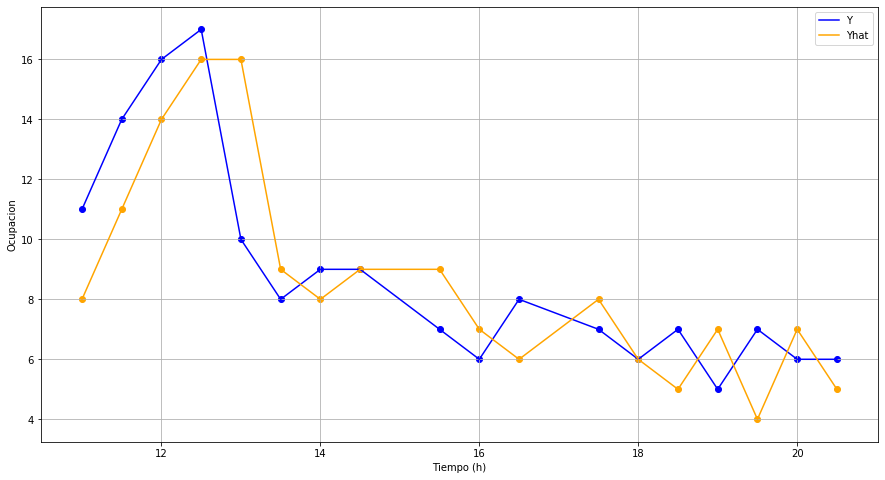

In [43]:
plot_predicted_data(model.predict(x_val1[input_features_no_cat_no_street]), x_val1, y_val1)

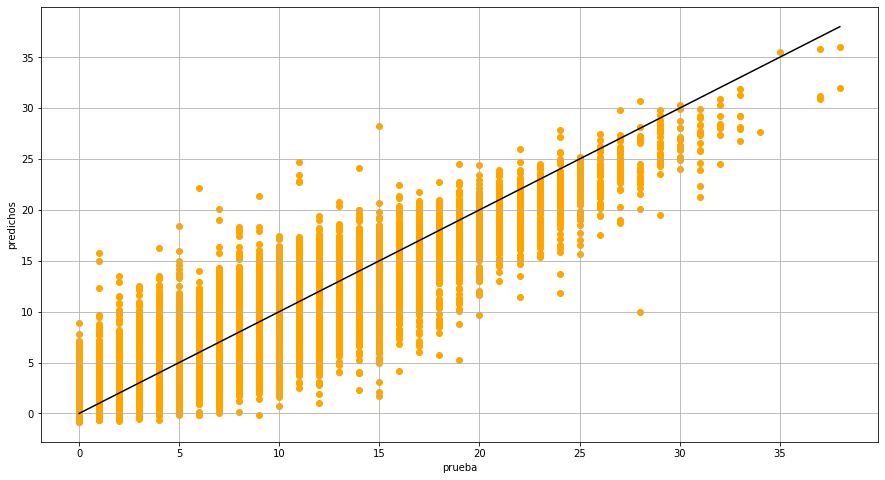

In [44]:
plt.scatter(y_test, model.predict(x_test[input_features_no_cat_no_street]), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

### Red neuronal

In [45]:
i = Input(shape=(len(input_features_no_cat_no_street)), name='input')
d = Dense(64, activation='relu')(i)
d = Dropout(0.3)(d)
d = Dense(64, activation='relu')(d)
o = Dense(1, activation='linear')(d)

model = Model(inputs=i, outputs=o)
model.summary()
model.compile(loss='MAE', optimizer='adam', metrics=['MSE'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [46]:
h = model.fit(x_train[input_features_no_cat_no_street], y_train, epochs=20, batch_size=128, validation_data=[x_test[input_features_no_cat_no_street],y_test])

Train on 375534 samples, validate on 41727 samples
Epoch 1/20
375534/375534 [==============================] - 5s 12us/sample - loss: 1.6871 - MSE: 5.0908 - val_loss: 2.0536 - val_MSE: 7.5771
Epoch 2/20
375534/375534 [==============================] - 4s 12us/sample - loss: 1.6085 - MSE: 4.5808 - val_loss: 2.0623 - val_MSE: 7.7760
Epoch 3/20
375534/375534 [==============================] - 4s 12us/sample - loss: 1.5925 - MSE: 4.4975 - val_loss: 2.1755 - val_MSE: 8.7191
Epoch 4/20
375534/375534 [==============================] - 4s 12us/sample - loss: 1.5810 - MSE: 4.4290 - val_loss: 2.1036 - val_MSE: 8.1765
Epoch 5/20
375534/375534 [==============================] - 4s 12us/sample - loss: 1.5727 - MSE: 4.3790 - val_loss: 2.1183 - val_MSE: 8.1783
Epoch 6/20
375534/375534 [==============================] - 4s 12us/sample - loss: 1.5631 - MSE: 4.3301 - val_loss: 2.1772 - val_MSE: 8.6929
Epoch 7/20
375534/375534 [==============================] - 4s 12us/sample - loss: 1.5484 - MSE: 4.2599

In [47]:
RMSE = sqrt(h.history['val_MSE'][len(h.history['val_MSE'])-1])
print("Score (R2):", r2_score(y_test, model.predict(x_test[input_features_no_cat_no_street])))
print('RMSE:', RMSE)

Score (R2): 0.6962449755130077
RMSE: 2.796703567791884


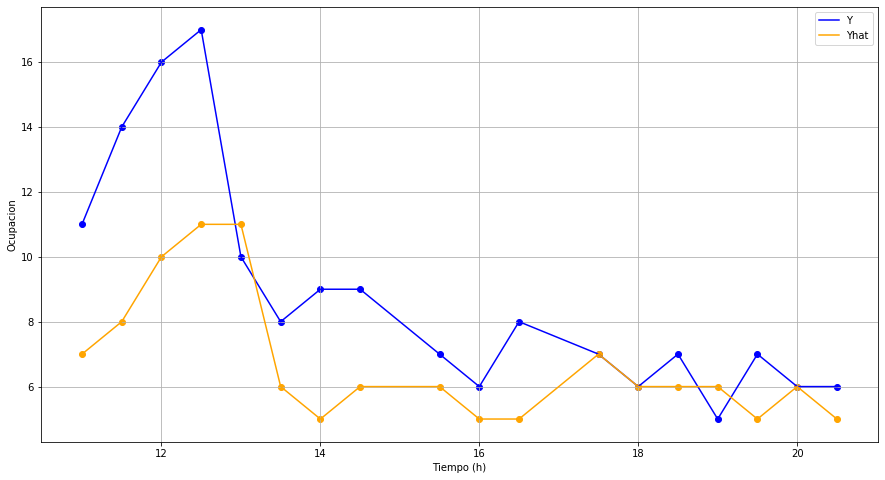

In [48]:
plot_predicted_data(model.predict(x_val1[input_features_no_cat_no_street]), x_val1, y_val1)

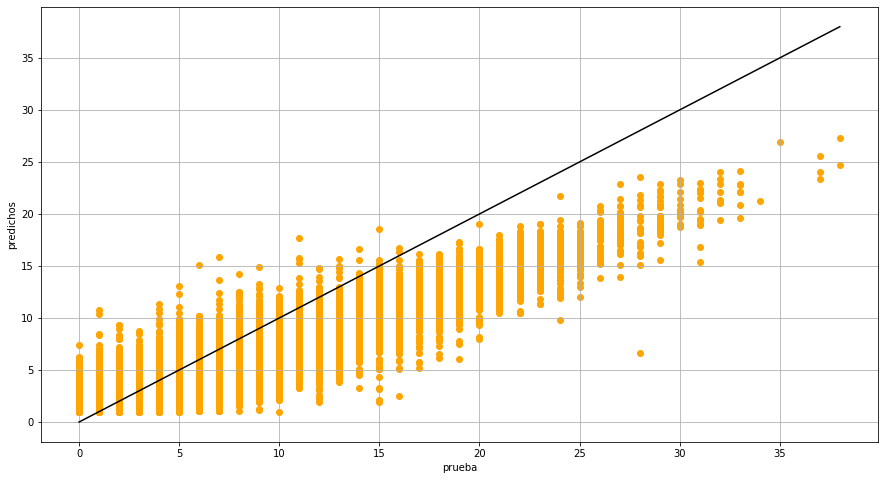

In [49]:
plt.scatter(y_test, model.predict(x_test[input_features_no_cat_no_street]), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

### Con embedding

In [50]:
i = Input(shape=((len(input_features_cat)-3)), name='input')

#id_cuadra
i_street = Input(shape=(1), name='input_street')
emb_street = Embedding(input_dim=max(data_to_split['id_cuadra'].drop_duplicates())+1, output_dim=10)(i_street)
flat_street = Flatten()(emb_street)

#Mes
i_month = Input(shape=(1), name='input_month')
emb_month = Embedding(input_dim=12+1, output_dim=10)(i_month)
flat_month = Flatten()(emb_month)

#dia de la semana
i_weekday = Input(shape=(1), name='input_id_cuadra')
emb_weekday = Embedding(input_dim=5, output_dim=10)(i_weekday)
flat_weekday = Flatten()(emb_weekday)


concat = Concatenate(axis=-1)
input_merge = concat([i, flat_street])
input_merge = concat([input_merge, flat_month])
input_merge = concat([input_merge, flat_weekday])

o = Dense(1, activation='linear')(input_merge)

model = Model(inputs=[i, i_street, i_month, i_weekday], outputs=o)
model.summary()
model.compile(loss='MAE', optimizer='adam', metrics=['MSE'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_street (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        1910        input_street[0][0]               
__________________________________________________________________________________________________
input_month (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input (InputLayer)              [(None, 3)]          0                                            
____________________________________________________________________________________________

In [51]:
x_train1 = x_train[[tiempo, 'ocupacion', 'ocupacion anterior']]
x_train2 = x_train['id_cuadra']
x_train3 = x_train['mes']
x_train4 = x_train['dia de la semana']
x_test1 = x_test[[tiempo, 'ocupacion', 'ocupacion anterior']]
x_test2 = x_test['id_cuadra']
x_test3 = x_test['mes']
x_test4 = x_test['dia de la semana']


h = model.fit([x_train1, x_train2, x_train3, x_train4], y_train, epochs=5, batch_size=64, validation_data=([x_test1, x_test2, x_test3, x_test4], y_test))

Train on 375534 samples, validate on 41727 samples
Epoch 1/5
375534/375534 [==============================] - 7s 20us/sample - loss: 1.6965 - MSE: 5.1603 - val_loss: 1.5531 - val_MSE: 4.1882
Epoch 2/5
375534/375534 [==============================] - 7s 20us/sample - loss: 1.5513 - MSE: 4.1608 - val_loss: 1.5546 - val_MSE: 4.1991
Epoch 3/5
375534/375534 [==============================] - 7s 20us/sample - loss: 1.5510 - MSE: 4.1611 - val_loss: 1.5528 - val_MSE: 4.1810
Epoch 4/5
375534/375534 [==============================] - 8s 20us/sample - loss: 1.5510 - MSE: 4.1612 - val_loss: 1.5522 - val_MSE: 4.1811
Epoch 5/5
375534/375534 [==============================] - 8s 20us/sample - loss: 1.5508 - MSE: 4.1600 - val_loss: 1.5535 - val_MSE: 4.1910


In [52]:
RMSE = sqrt(h.history['val_MSE'][len(h.history['val_MSE'])-1])
print("Score (R2):", r2_score(y_test, model.predict([x_test1, x_test2, x_test3, x_test4])))
print('RMSE:', RMSE)

Score (R2): 0.8372378343477399
RMSE: 2.047204959278428


In [53]:
model.layers[1].get_weights()[0] #['id_cuadra', 'mes', 'dia de la semana', tiempo, 'ocupacion', 'ocupacion anterior']

array([[-0.16166803,  0.17154916, -0.22856176, ..., -0.1350212 ,
        -0.12364603,  0.13772339],
       [-0.11471479,  0.13793242, -0.12244928, ..., -0.06506955,
        -0.10767958,  0.10843457],
       [-0.04654097,  0.02034262, -0.05180072, ...,  0.01056808,
        -0.02570785, -0.02935417],
       ...,
       [ 0.00132444, -0.03303155,  0.00633556, ..., -0.00056624,
        -0.00747548,  0.01476376],
       [ 0.00744624, -0.01737835,  0.00521374, ...,  0.01618494,
        -0.00794488, -0.02948881],
       [ 0.17481448, -0.17978309,  0.18025033, ...,  0.2584971 ,
         0.24564633, -0.26005054]], dtype=float32)

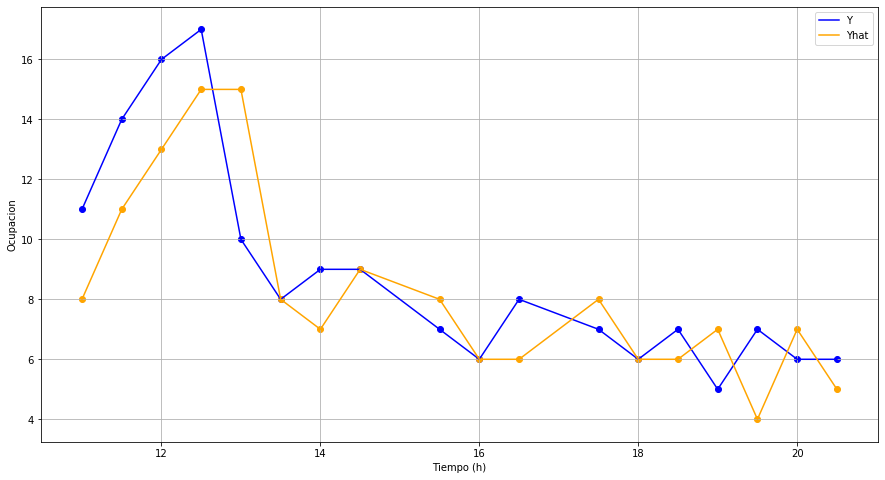

In [54]:
plot_predicted_data(model.predict([x_val1[[tiempo, 'ocupacion', 'ocupacion anterior']], x_val1['id_cuadra'], x_val1['mes'], x_val1['dia de la semana']]), x_val1, y_val1)

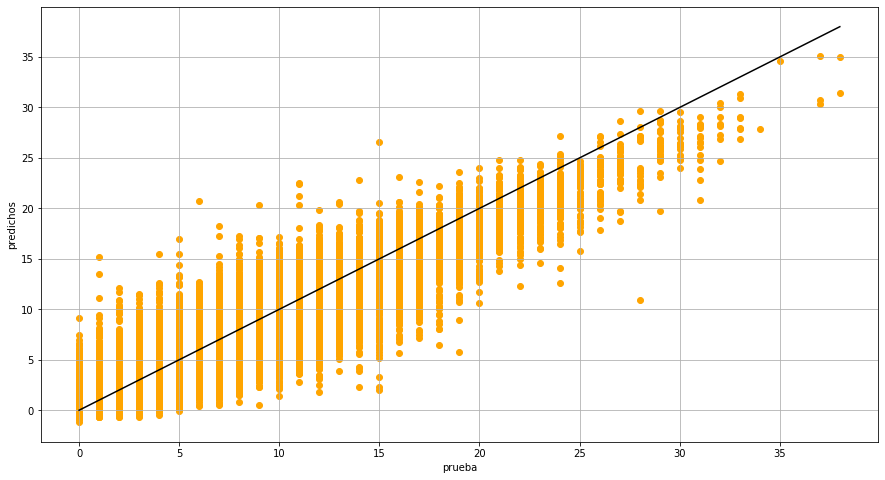

In [55]:
plt.scatter(y_test, model.predict([x_test[[tiempo, 'ocupacion', 'ocupacion anterior']], x_test['id_cuadra'], x_test['mes'], x_test['dia de la semana']]), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

### Lo mismo pero con mas capas

In [56]:
i = Input(shape=((len(input_features_cat)-3)), name='input')

#id_cuadra
i_street = Input(shape=(1), name='input_street')
emb_street = Embedding(input_dim=max(data_to_split['id_cuadra'].drop_duplicates())+1, output_dim=10)(i_street)
flat_street = Flatten()(emb_street)

#Mes
i_month = Input(shape=(1), name='input_month')
emb_month = Embedding(input_dim=12+1, output_dim=10)(i_month)
flat_month = Flatten()(emb_month)

#dia de la semana
i_weekday = Input(shape=(1), name='input_id_cuadra')
emb_weekday = Embedding(input_dim=5, output_dim=10)(i_weekday)
flat_weekday = Flatten()(emb_weekday)


concat = Concatenate(axis=-1)
input_merge = concat([i, flat_street])
input_merge = concat([input_merge, flat_month])
input_merge = concat([input_merge, flat_weekday])

d = Dense(64, activation='relu')(input_merge)
d = Dense(64, activation='relu')(d)
d = Dropout(0.3)(d)
d = Dense(64, activation='relu')(d)
o = Dense(1, activation='linear')(d)

model = Model(inputs=[i, i_street, i_month, i_weekday], outputs=o)
model.summary()
model.compile(loss='MAE', optimizer='adam', metrics=['MSE'])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_street (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 10)        1910        input_street[0][0]               
__________________________________________________________________________________________________
input_month (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input (InputLayer)              [(None, 3)]          0                                            
____________________________________________________________________________________________

In [57]:
x_train1 = x_train[[tiempo, 'ocupacion', 'ocupacion anterior']]
x_train2 = x_train['id_cuadra']
x_train3 = x_train['mes']
x_train4 = x_train['dia de la semana']
x_test1 = x_test[[tiempo, 'ocupacion', 'ocupacion anterior']]
x_test2 = x_test['id_cuadra']
x_test3 = x_test['mes']
x_test4 = x_test['dia de la semana']


h = model.fit([x_train1, x_train2, x_train3, x_train4], y_train, epochs=20, batch_size=128, validation_data=([x_test1, x_test2, x_test3, x_test4], y_test))

Train on 375534 samples, validate on 41727 samples
Epoch 1/20
375534/375534 [==============================] - 6s 16us/sample - loss: 1.6065 - MSE: 4.6240 - val_loss: 2.0805 - val_MSE: 7.8033
Epoch 2/20
375534/375534 [==============================] - 6s 16us/sample - loss: 1.5220 - MSE: 4.0626 - val_loss: 2.0134 - val_MSE: 7.3344
Epoch 3/20
375534/375534 [==============================] - 6s 16us/sample - loss: 1.4997 - MSE: 3.9487 - val_loss: 2.1104 - val_MSE: 8.0833
Epoch 4/20
375534/375534 [==============================] - 6s 15us/sample - loss: 1.4704 - MSE: 3.8095 - val_loss: 2.1157 - val_MSE: 8.2077
Epoch 5/20
375534/375534 [==============================] - 6s 16us/sample - loss: 1.4502 - MSE: 3.7126 - val_loss: 2.1020 - val_MSE: 8.0426
Epoch 6/20
375534/375534 [==============================] - 6s 15us/sample - loss: 1.4377 - MSE: 3.6473 - val_loss: 1.9277 - val_MSE: 6.7896
Epoch 7/20
375534/375534 [==============================] - 6s 16us/sample - loss: 1.4310 - MSE: 3.6164

In [58]:
RMSE = sqrt(h.history['val_MSE'][len(h.history['val_MSE'])-1])
print("Score (R2):", r2_score(y_test, model.predict([x_test1, x_test2, x_test3, x_test4])))
print('RMSE:', RMSE)

Score (R2): 0.7281982562640665
RMSE: 2.645517906149995


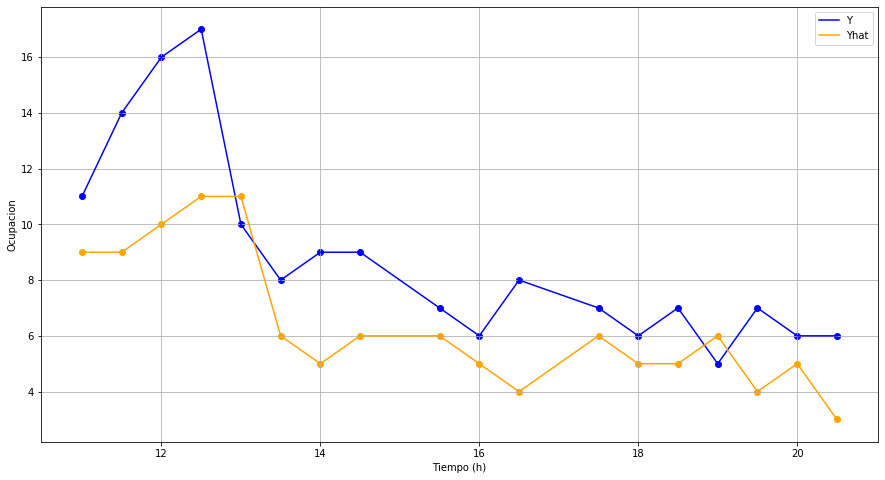

In [59]:
plot_predicted_data(model.predict([x_val1[[tiempo, 'ocupacion', 'ocupacion anterior']], x_val1['id_cuadra'], x_val1['mes'], x_val1['dia de la semana']]), x_val1, y_val1)

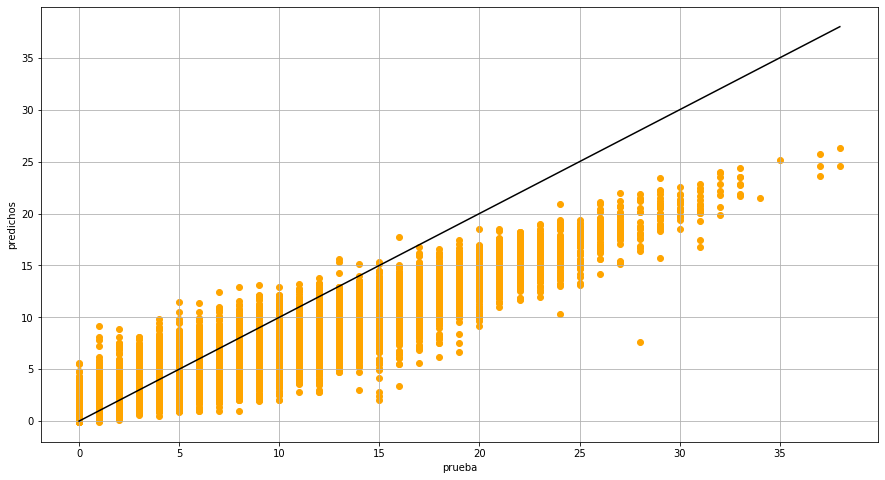

In [60]:
plt.scatter(y_test, model.predict([x_test[[tiempo, 'ocupacion', 'ocupacion anterior']], x_test['id_cuadra'], x_test['mes'], x_test['dia de la semana']]), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

In [61]:
print(model.predict([x_val1[[tiempo, 'ocupacion', 'ocupacion anterior']], x_val1['id_cuadra'], x_val1['mes'], x_val1['dia de la semana']]))
print(y_val1)

[[ 8.930586 ]
 [ 9.328885 ]
 [10.432237 ]
 [11.304689 ]
 [11.256757 ]
 [ 6.119552 ]
 [ 5.0176606]
 [ 5.923187 ]
 [ 6.218217 ]
 [ 4.9542823]
 [ 4.4415326]
 [ 6.0401063]
 [ 5.3579288]
 [ 4.8478026]
 [ 5.622918 ]
 [ 3.9108877]
 [ 4.693714 ]
 [ 3.0319057]]
69693    11
69694    14
69695    16
69696    17
69697    10
69698     8
69699     9
69700     9
69701     7
69702     6
69703     8
69704     7
69705     6
69706     7
69707     5
69708     7
69709     6
69710     6
Name: targets, dtype: object


# LSTM

### Se eligen valores de input

In [18]:
d = data_no_outliers.copy()

In [19]:
#Esto es si lo quiero con outliers
d = data.copy()

In [20]:
d

,dia de la semana,fecha,id_cuadra,media hora,mes,ocupacion,ocupacion anterior,targets
0,2,2019-01-02,0,36000,1,2,3,1
1,2,2019-01-02,0,37800,1,1,2,5
2,2,2019-01-02,0,39600,1,5,1,4
3,2,2019-01-02,0,41400,1,4,5,2
4,2,2019-01-02,0,43200,1,2,4,3
...,...,...,...,...,...,...,...,...
476452,1,2019-09-17,190,39600,9,1,1,1
476453,1,2019-09-17,190,41400,9,1,1,1
476454,1,2019-11-12,190,36000,11,0,0,1
476455,1,2019-11-19,190,34200,11,1,1,1


In [21]:
input_features = ['id_cuadra', 'mes', 'dia de la semana', 'ocupacion']

train_size = 3

### Se eligen datos de validacion

In [22]:
cuadra1 = 12
fecha1 = 1

fecha1 = d['fecha'].drop_duplicates().iloc[fecha1]

filt = (d['id_cuadra'] == cuadra1) & (d['fecha'] == fecha1) 
x_val1 = d.loc[filt, ['ocupacion','media hora']]
y_val1 = d.loc[filt, 'targets']

d = d.loc[~filt]


inp_val =[]
inp_time =[]
target_val =[]
for i in range(len(x_val1) - train_size):
    inp_val.append(x_val1['ocupacion'].iloc[i:i+train_size])
    
    inp_time.append(x_val1['media hora'].iloc[i+train_size])

    target_val.append(y_val1.iloc[i+train_size])

### Se prepara todo para la LSTM

In [23]:
emb_data = []
time = []
inp = []
target = []
for s in d['id_cuadra'].drop_duplicates().sort_values():
    clear_output()
    print('calle:', s)
    
    d_s = d.loc[d['id_cuadra'] == s].copy()
    
    for f in d_s['fecha'].drop_duplicates():
        d_f = d_s.loc[d['fecha'] == f]
        
        for i in range(len(d_f) - train_size):
            inp.append(d_f['ocupacion'].iloc[i:i+train_size])
            emb_data.append(d_f[['id_cuadra', 'mes', 'dia de la semana']].iloc[i+train_size-1])
            time.append(d_f['media hora'].iloc[i+train_size-1])
            
            target.append(d_f['targets'].iloc[i+train_size])

calle: 190


### Se divide en test y train

In [24]:
emb_data_df = pd.DataFrame(emb_data)
inp_df = np.array(inp).reshape(-1,train_size,1)
time_df = np.array(time) / (1800*2)
target_df = np.array(target)

In [25]:
from random import shuffle

to_shuffle = list(zip(inp_df, emb_data_df.to_numpy(), time_df, target_df))
shuffle(to_shuffle)
inp_df, emb_data_df, time_df, target_df = zip(*to_shuffle)

In [26]:
train_test = int(len(d) * 0.1)

train_inp = inp_df[train_test:]
train_emb_data = emb_data_df[train_test:]
train_time = time_df[train_test:]
train_target = target_df[train_test:]

test_inp = inp_df[:train_test]
test_emb_data = emb_data_df[:train_test]
test_time = time_df[:train_test]
test_target = target_df[:train_test]

### LSTM

In [27]:
i_time = Input(shape=(1), name='input_time')

#id_cuadra
i_street = Input(shape=(1), name='input_street')
emb_street = Embedding(input_dim=max(data_to_split['id_cuadra'].drop_duplicates())+1, output_dim=10)(i_street)
flat_street = Flatten()(emb_street)

#Mes
i_month = Input(shape=(1), name='input_month')
emb_month = Embedding(input_dim=12+1, output_dim=10)(i_month)
flat_month = Flatten()(emb_month)

#dia de la semana
i_weekday = Input(shape=(1), name='input_id_cuadra')
emb_weekday = Embedding(input_dim=5, output_dim=10)(i_weekday)
flat_weekday = Flatten()(emb_weekday)

i_ocup = Input(shape=(train_size,1), name='input_ocup')
lstm = LSTM(10, return_sequences=False, name='lstm')(i_ocup)

concat = Concatenate(axis=-1)
input_merge = concat([i_time, flat_street])
input_merge = concat([input_merge, flat_month])
input_merge = concat([input_merge, flat_weekday])
input_merge = concat([input_merge, lstm])

o = Dense(1, activation='linear')(input_merge)

model = Model(inputs=[i_time, i_street, i_month, i_weekday, i_ocup], outputs=o)
model.summary()
model.compile(loss='MSE', optimizer='adam', metrics=['MAE'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_street (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        1910        input_street[0][0]               
__________________________________________________________________________________________________
input_month (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_time (InputLayer)         [(None, 1)]          0                                            
______________________________________________________________________________________________

In [28]:
train_emb_data = pd.DataFrame(train_emb_data) 
test_emb_data = pd.DataFrame(test_emb_data) #id, mes, weekday
train_time = np.array(train_time) 
test_time = np.array(test_time) 

In [29]:
x_train = [train_time, train_emb_data[0], train_emb_data[1], train_emb_data[2], train_inp]
x_test = [test_time, test_emb_data[0], test_emb_data[1], test_emb_data[2], test_inp]

In [43]:
train_target = np.array(train_target)
test_target = np.array(test_target)

In [62]:
x_train[4] = np.array(x_train[4])
x_test[4] = np.array(x_test[4])

In [63]:
h = model.fit(x_train, train_target, epochs=10, batch_size=64, validation_data=[x_test, test_target])

Train on 328621 samples, validate on 44317 samples
Epoch 1/10
328621/328621 [==============================] - 24s 73us/sample - loss: 11.2075 - MAE: 2.4220 - val_loss: 8.2743 - val_MAE: 2.1680
Epoch 2/10
328621/328621 [==============================] - 23s 71us/sample - loss: 8.0276 - MAE: 2.1521 - val_loss: 8.1181 - val_MAE: 2.1671
Epoch 3/10
328621/328621 [==============================] - 23s 71us/sample - loss: 7.9639 - MAE: 2.1472 - val_loss: 8.0814 - val_MAE: 2.1588
Epoch 4/10
328621/328621 [==============================] - 23s 71us/sample - loss: 7.9487 - MAE: 2.1465 - val_loss: 8.1186 - val_MAE: 2.1571
Epoch 5/10
328621/328621 [==============================] - 23s 71us/sample - loss: 7.9399 - MAE: 2.1455 - val_loss: 8.0785 - val_MAE: 2.1625
Epoch 6/10
328621/328621 [==============================] - 23s 71us/sample - loss: 7.9331 - MAE: 2.1450 - val_loss: 8.0612 - val_MAE: 2.1639
Epoch 7/10
328621/328621 [==============================] - 23s 70us/sample - loss: 7.9278 - MAE

In [64]:
RMSE = sqrt(h.history['val_loss'][len(h.history['val_loss'])-1])
print("Score (R2):", r2_score(test_target, model.predict(x_test)))
print('RMSE:', RMSE)

Score (R2): 0.729538111033881
RMSE: 2.841732795815052


In [65]:
#inp_val = tf.convert_to_tensor(np.array(inp_val).reshape(-1, train_size, 1), np.float64)

ValueError: x and y must be the same size

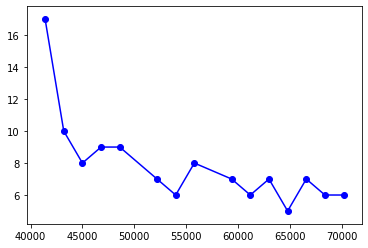

In [66]:
plot_predicted_data(model.predict(x_test), x_val1[train_size:], target_val)

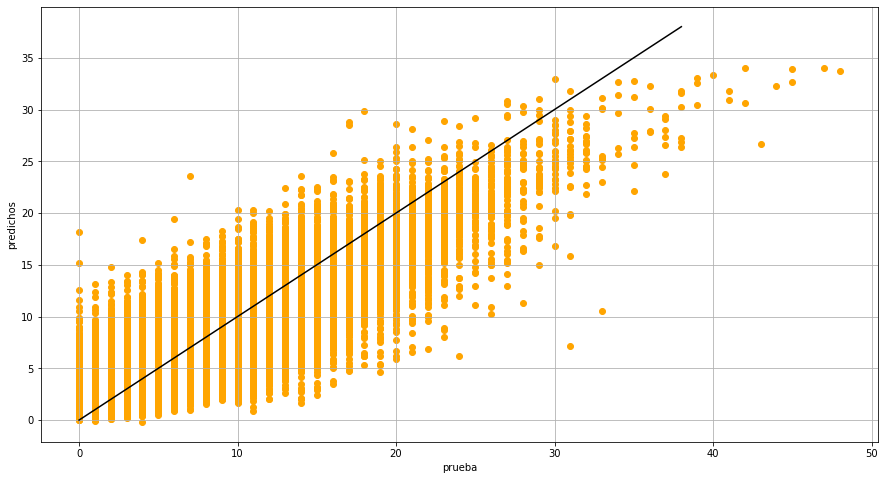

In [73]:
plt.scatter(test_target, model.predict(x_test), color='orange')
plt.plot(range(0, int(y_test.max())+1), range(0, int(y_test.max())+1), color='black')
plt.grid()
plt.xlabel('prueba')
plt.ylabel('predichos')
plt.show()

In [68]:
print('y_pred:', np.array([round(y) for x in model.predict(x_train) for y in x]))
print('y:     ', target_val)

y_pred: [ 7.  5.  4. ...  5.  2. 17.]
y:      [17, 10, 8, 9, 9, 7, 6, 8, 7, 6, 7, 5, 7, 6, 6]


In [69]:
x_test

[array([17.5, 12.5, 18. , ..., 15.5, 17. , 12. ]), 0        36
 1        20
 2        31
 3        40
 4        91
          ..
 44312    91
 44313    51
 44314    20
 44315    60
 44316    38
 Name: 0, Length: 44317, dtype: int64, 0        11
 1         6
 2         8
 3         7
 4         5
          ..
 44312     3
 44313     6
 44314     1
 44315    11
 44316     3
 Name: 1, Length: 44317, dtype: int64, 0        4
 1        3
 2        1
 3        1
 4        3
         ..
 44312    4
 44313    4
 44314    3
 44315    1
 44316    3
 Name: 2, Length: 44317, dtype: int64, array([[[ 1],
         [ 0],
         [ 1]],
 
        [[14],
         [12],
         [ 9]],
 
        [[18],
         [17],
         [13]],
 
        ...,
 
        [[ 3],
         [ 3],
         [ 0]],
 
        [[13],
         [12],
         [ 7]],
 
        [[13],
         [15],
         [ 8]]], dtype=int64)]

In [70]:
test_time[0] 

17.5

In [72]:
plt.rcParams['figure.figsize'] = (15,8)
